# CAFA 5 Competition : Protein Function Prediction

# Problem Framing

This Kaggle competition aims to predict the function of proteins using their amino-acid sequences and additional data. Understanding protein function is crucial for comprehending cellular processes and developing new treatments for diseases. With the abundance of genomic sequence data available, assigning accurate biological functions to proteins becomes challenging due to their multifunctionality and interactions with various partners. This competition, hosted by the Function Community of Special Interest (Function-COSI), brings together computational biologists, experimental biologists, and biocurators to improve protein function prediction through data science and machine learning approaches. The goal is to contribute to advancements in medicine, agriculture, and overall human and animal health.

![image-intro](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Computational_solvent_mapping_of_AMA1_using_FTMAP.TIF/lossy-page1-500px-Computational_solvent_mapping_of_AMA1_using_FTMAP.TIF.jpg)

# What to submit ?

This competition evaluates participants' predictions of Gene Ontology (GO) terms for protein sequences. The evaluation is performed on a test set of proteins that initially have no assigned functions but may accumulate experimental annotations after the submission deadline. The test set is divided into three subontologies: Molecular Function (MF), Biological Process (BP), and Cellular Component (CC). Participants are scored separately for each subontology. The final performance measure is the arithmetic mean of the maximum F-measures calculated on the three subontologies. Weighted precision and recall are used, taking into account the hierarchical structure of the GO. The evaluation code is publicly available. The leaderboard displays performance on a subset of proteins not included in the final test set, so generalization performance is crucial. Submission files should contain protein-target pairs with corresponding GO terms and estimated probabilities, within a specific score range. The predictions are propagated to parent terms if not explicitly listed. There is a limit on the number of terms associated with each protein. If a protein is not listed in the submission file, it is assumed that all predictions for that protein are zero.

In [1]:
import pandas as pd
sub = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv", sep= "\t", header = None)
sub.columns = ["The Protein ID", "The Gene Ontology term (GO) ID", "Predicted link probability that GO appear in Protein"]
sub.head(5)

,The Protein ID,The Gene Ontology term (GO) ID,Predicted link probability that GO appear in Protein
0,A0A0A0MRZ7,GO:0000001,0.123
1,A0A0A0MRZ7,GO:0000002,0.123
2,A0A0A0MRZ8,GO:0000001,0.123
3,A0A0A0MRZ8,GO:0000002,0.123
4,A0A0A0MRZ9,GO:0000001,0.123


The evaluation metric used in this competition is the weighted F-measure, which combines precision and recall, taking into account the hierarchical structure of the Gene Ontology (GO). The formula for calculating the weighted F-measure is as follows:

$Weighted \ F-measure = \frac{(1 + β^2) * (weighted \ precision * weighted recall)}{((β^2 * weighted \ precision) + weighted \ recall)}$

where:
- β is a parameter that controls the trade-off between precision and recall. In this competition, β is set to 1, resulting in an equal weighting of precision and recall.
- Weighted precision is the precision score, considering the weights of the predicted terms. It is calculated as the sum of the products of the predicted term's weight and its true positive count, divided by the sum of the weights of all predicted terms.
- Weighted recall is the recall score, considering the weights of the true positive terms. It is calculated as the sum of the products of the true positive term's weight and its count, divided by the sum of the weights of all true positive terms.

Note: The specific formulas for weighted precision and weighted recall are provided in the competition materials and utilize additional information such as term weights and true positive counts.

# General Baseline in this Notebook

- **1 - Collect Embedding vectors from pre-trained protein function prediction models (T5, ProtBERT or EMS2) :**

Sources for embeddings vectors : 
- *T5* : https://www.kaggle.com/datasets/sergeifironov/t5embeds

- *ProtBERT* : https://www.kaggle.com/datasets/henriupton/protbert-embeddings-for-cafa5

- *EMS2* : https://www.kaggle.com/datasets/viktorfairuschin/cafa-5-ems-2-embeddings-numpy

- **2 - Generate labels from train_terms file** : by considering the top K most common GO terms in all Proteins set, generate for each protein a sparse vector of length K to indicate the true probabilities that each of the K GO terms are in the Protein (0 or 1). Here we retain K = 600

- **3 - Create Pytorch Dataset class that can handle Protein ID and embeddings**.

- **4 - Create Pytorch Model class for prediction** : can be any architecture of Multilabel classification model that can turn embeddings of shape (E,) to probabilities of shape (K,). Here we explore **MultiLayerPerceptron** and **ConvNN1d** Networks.

- **5 - Make Cross Validation w.r.t the F-1 measure and do Hyperparameter tuning thanks to Weights and Biases package (Wandb)**

![baseline-image](https://www.researchgate.net/publication/334642149/figure/fig1/AS:783995214249986@1563930433525/Flow-chart-of-STRING2GO-based-protein-function-prediction-method.png)

## **Flow-chart of STRING2GO-based protein function prediction method**

# So now lets get started !

# 1. Imports / Config

In [2]:
MAIN_DIR = "/kaggle/input/cafa-5-protein-function-prediction"

# UTILITARIES
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

# FILES VISUALIZATION
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_ids.npy
/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_embeddings.npy
/kaggle/input/cafa-5-ems-2-embeddings-numpy/test_ids.npy
/kaggle/input/cafa-5-ems-2-embeddings-numpy/test_embeddings.npy
/kaggle/input/protbert-embeddings-for-cafa5/train_ids.npy
/kaggle/input/protbert-embeddings-for-cafa5/train_embeddings.npy
/kaggle/input/protbert-embeddings-for-cafa5/test_ids.npy
/kaggle/input/protbert-embeddings-for-cafa5/test_embeddings.npy
/kaggle/input/t5embeds/train_ids.npy
/kaggle/input/t5embeds/test_embeds.npy
/kaggle/input/t5embeds/train_embeds.npy
/kaggle/input/t5embeds/test_ids.npy
/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-5-protein-function-prediction/IA.txt
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset-taxon-list.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/tra

In [3]:
class config:
    train_sequences_path = MAIN_DIR  + "/Train/train_sequences.fasta"
    train_labels_path = MAIN_DIR + "/Train/train_terms.tsv"
    test_sequences_path = MAIN_DIR + "/Test (Targets)/testsuperset.fasta"
    
    num_labels = 500
    n_epochs = 5
    batch_size = 128
    lr = 0.001
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print(config.device)

cuda


# 2. Baseline

- Use ProtBERT/T5 embedding vectors for each Sequence ID and its associated Protein Sequence. 

- Define a Pytorch Dataset to load all ids/sequences of the train+test sets and their respective ProtBert embeddings

- Define Pytorch Model architecture in order to use these embeddings to proceed classification task : to each ID we associate a probability to be associated to each GO term **For this part, just consider the top_n most common GO terms as labels**

- Return desired probabilities for test set

# 3. Collect ProtBERT Embedding Vectors

### Here is a Dataset Card I have created if you want to understand better what are pre-trained model embedding vectors, and if you want to download it directly from it : https://www.kaggle.com/datasets/henriupton/protbert-embeddings-for-cafa5

##### SCRIPT FOR VECTOR EMBEDDINGS COLLECTING #####
#### RUN THIS ONLY ONE TIME AND SAVE IT IN LOCAL ####

```python

print("Load ProtBERT Model...")
# PROT BERT LOADING :
from transformers import BertModel, BertTokenizer
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert").to(config.device)

def get_bert_embedding(
    sequence : str,
    len_seq_limit : int
):
    '''
    Function to collect last hidden state embedding vector from pre-trained ProtBERT Model
    
    INPUTS:
    - sequence (str) : protein sequence (ex : AAABBB) from fasta file
    - len_seq_limit (int) : maximum sequence lenght (i.e nb of letters) for truncation
    
    OUTPUTS:
    - output_hidden : last hidden state embedding vector for input sequence of length 1024
    '''
    sequence_w_spaces = ' '.join(list(sequence))
    encoded_input = tokenizer(
        sequence_w_spaces,
        truncation=True,
        max_length=len_seq_limit,
        padding='max_length',
        return_tensors='pt').to(config.device)
    output = model(**encoded_input)
    output_hidden = output['last_hidden_state'][:,0][0].detach().cpu().numpy()
    assert len(output_hidden)==1024
    return output_hidden

### COLLECTING FOR TRAIN SAMPLES :
print("Loading train set ProtBERT Embeddings...")
fasta_train = SeqIO.parse(config.train_sequences_path, "fasta")
print("Total Nb of Elements : ", len(list(fasta_train)))
fasta_train = SeqIO.parse(config.train_sequences_path, "fasta")
ids_list = []
embed_vects_list = []
t0 = time.time()
checkpoint = 0
for item in tqdm(fasta_train):
    ids_list.append(item.id)
    embed_vects_list.append(
        get_bert_embedding(sequence = item.seq, len_seq_limit = 1200))
    checkpoint+=1
    if checkpoint>=100:
        df_res = pd.DataFrame(data={"id" : ids_list, "embed_vect" : embed_vects_list})
        np.save('/kaggle/working/train_ids.npy',np.array(ids_list))
        np.save('/kaggle/working/train_embeddings.npy',np.array(embed_vects_list))
        checkpoint=0
        
np.save('/kaggle/working/train_ids.npy',np.array(ids_list))
np.save('/kaggle/working/train_embeddings.npy',np.array(embed_vects_list))
print('Total Elapsed Time:',time.time()-t0)

### COLLECTING FOR TEST SAMPLES :
print("Loading test set ProtBERT Embeddings...")
fasta_test = SeqIO.parse(config.test_sequences_path, "fasta")
print("Total Nb of Elements : ", len(list(fasta_test)))
fasta_test = SeqIO.parse(config.test_sequences_path, "fasta")
ids_list = []
embed_vects_list = []
t0 = time.time()
checkpoint=0
for item in tqdm(fasta_test):
    ids_list.append(item.id)
    embed_vects_list.append(
        get_bert_embedding(sequence = item.seq, len_seq_limit = 1200))
    checkpoint+=1
    if checkpoint>=100:
        np.save('/kaggle/working/test_ids.npy',np.array(ids_list))
        np.save('/kaggle/working/test_embeddings.npy',np.array(embed_vects_list))
        checkpoint=0
        
np.save('/kaggle/working/test_ids.npy',np.array(ids_list))
np.save('/kaggle/working/test_embeddings.npy',np.array(embed_vects_list))
print('Total Elasped Time:',time.time()-t0)
```

# 4. Collect labels vectors for train/test

In [5]:
##### SCRIPT FOR LABELS (TARGETS) VECTORS COLLECTING #####

#```python
print("GENERATE TARGETS FOR ENTRY IDS ("+str(config.num_labels)+" MOST COMMON GO TERMS)")
ids = np.load("/kaggle/input/protbert-embeddings-for-cafa5/train_ids.npy")
labels = pd.read_csv(config.train_labels_path, sep = "\t")

top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
labels_names = top_terms[:config.num_labels].index.values
train_labels_sub = labels[(labels.term.isin(labels_names)) & (labels.EntryID.isin(ids))]
id_labels = train_labels_sub.groupby('EntryID')['term'].apply(list).to_dict()

go_terms_map = {label: i for i, label in enumerate(labels_names)}
labels_matrix = np.empty((len(ids), len(labels_names)))

for index, id in tqdm(enumerate(ids)):
    id_gos_list = id_labels[id]
    temp = [go_terms_map[go] for go in labels_names if go in id_gos_list]
    labels_matrix[index, temp] = 1

labels_list = []
for l in range(labels_matrix.shape[0]):
    labels_list.append(labels_matrix[l, :])

labels_df = pd.DataFrame(data={"EntryID":ids, "labels_vect":labels_list})
labels_df.to_pickle("/kaggle/working/train_targets_top"+str(config.num_labels)+".pkl")
print("GENERATION FINISHED!")
#```

GENERATE TARGETS FOR ENTRY IDS (500 MOST COMMON GO TERMS)


142246it [01:01, 2327.38it/s]


GENERATION FINISHED!


# 5. Pytorch Dataset Architecture

In [6]:
# Directories for the different embedding vectors : 
embeds_map = {
    "T5" : "t5embeds",
    "ProtBERT" : "protbert-embeddings-for-cafa5",
    "EMS2" : "cafa-5-ems-2-embeddings-numpy"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "EMS2" : 1280
}

In [7]:
class ProteinSequenceDataset(Dataset):
    
    def __init__(self, datatype, embeddings_source):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        
        if embeddings_source in ["ProtBERT", "EMS2"]:
            embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
            ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
        
        if embeddings_source == "T5":
            embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
            ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
            
        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
        if datatype=="train":
            df_labels = pd.read_pickle(
                "/kaggle/working/train_targets_top"+str(config.num_labels)+".pkl")
            self.df = self.df.merge(df_labels, on="EntryID")
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id
        

In [8]:
dataset = ProteinSequenceDataset(datatype="train",embeddings_source="T5")

In [9]:
embeddings, labels = dataset.__getitem__(0)
print("COMPONENTS FOR FIRST PROTEIN : ")
print("EMBEDDINGS VECTOR : \n ", embeddings, "\n")
print("TARGETS LABELS VECTOR : \n ", labels, "\n")

COMPONENTS FOR FIRST PROTEIN : 
EMBEDDINGS VECTOR : 
  tensor([ 0.0495, -0.0329,  0.0325,  ..., -0.0435,  0.0965,  0.0731]) 

TARGETS LABELS VECTOR : 
  tensor([0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,

# 6. Pytorch Models Architectures

In [10]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 1012)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(1012, 712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(712, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x

In [11]:
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        # (batch_size, channels, embed_size)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 3, embed_size)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 3, embed_size/2 = 512)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 8, embed_size/2 = 512)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 8, embed_size/4 = 256)
        self.fc1 = nn.Linear(in_features=int(8 * input_dim/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# 7. Train the Model

In [12]:
def train_model(embeddings_source, model_type="linear", train_size=0.9):
    
    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source)
    
    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
    n_epochs = config.n_epochs

    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]
    
    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item()) 
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)
        
        ## VALIDATION PHASE : 
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(config.device), targets.to(config.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)
        
        scheduler.step(avg_loss)
        print("\n")
        
    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])
    
    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}
    
    return model, losses_history, scores_history

## 7.1. Training Usecase

In [13]:
ems2_model, ems2_losses, ems2_scores = train_model(embeddings_source="EMS2",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 1001/1001 [00:25<00:00, 39.76it/s]


Running Average TRAIN Loss :  132.47256845479959
Running Average TRAIN F1-Score :  0.15920529057542523
Running Average VAL Loss :  129.81104053769792
Running Average VAL F1-Score :  0.1863000996943031


EPOCH  2


100%|██████████| 1001/1001 [00:24<00:00, 41.37it/s]


Running Average TRAIN Loss :  128.88759090945675
Running Average TRAIN F1-Score :  0.1927813611902319
Running Average VAL Loss :  128.44544662748064
Running Average VAL F1-Score :  0.19774561268942698


EPOCH  3


100%|██████████| 1001/1001 [00:24<00:00, 40.72it/s]


Running Average TRAIN Loss :  127.5511232846743
Running Average TRAIN F1-Score :  0.20440208405762406
Running Average VAL Loss :  127.45537083489555
Running Average VAL F1-Score :  0.2055709431213992


EPOCH  4


100%|██████████| 1001/1001 [00:24<00:00, 41.52it/s]


Running Average TRAIN Loss :  126.52975014182594
Running Average TRAIN F1-Score :  0.21401370780451315
Running Average VAL Loss :  127.07108300072807
Running Average VAL F1-Score :  0.21275311668536492


EPOCH  5


100%|██████████| 1001/1001 [00:24<00:00, 41.43it/s]


Running Average TRAIN Loss :  125.66190741326544
Running Average TRAIN F1-Score :  0.22222193314895763
Running Average VAL Loss :  126.41400705065045
Running Average VAL F1-Score :  0.21750457391941122


TRAINING FINISHED
FINAL TRAINING SCORE :  0.22222193314895763
FINAL VALIDATION SCORE :  0.21750457391941122


In [14]:
t5_model, t5_losses, t5_scores = train_model(embeddings_source="T5",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 1001/1001 [00:23<00:00, 42.13it/s]


Running Average TRAIN Loss :  131.63943539370786
Running Average TRAIN F1-Score :  0.16887766550798397
Running Average VAL Loss :  127.27282960074288
Running Average VAL F1-Score :  0.19564900919795036


EPOCH  2


100%|██████████| 1001/1001 [00:23<00:00, 42.79it/s]


Running Average TRAIN Loss :  127.77615195625907
Running Average TRAIN F1-Score :  0.20406948680525178
Running Average VAL Loss :  126.08672850472587
Running Average VAL F1-Score :  0.20690402973975455


EPOCH  3


100%|██████████| 1001/1001 [00:23<00:00, 42.06it/s]


Running Average TRAIN Loss :  126.21333077475504
Running Average TRAIN F1-Score :  0.21660974620284137
Running Average VAL Loss :  125.41153369631085
Running Average VAL F1-Score :  0.2171755534197603


EPOCH  4


100%|██████████| 1001/1001 [00:24<00:00, 41.38it/s]


Running Average TRAIN Loss :  125.00049887551414
Running Average TRAIN F1-Score :  0.22794590406603626
Running Average VAL Loss :  124.4958519254412
Running Average VAL F1-Score :  0.224016036705247


EPOCH  5


100%|██████████| 1001/1001 [00:24<00:00, 41.55it/s]


Running Average TRAIN Loss :  123.86796485984718
Running Average TRAIN F1-Score :  0.23797318835060793
Running Average VAL Loss :  124.21995428630284
Running Average VAL F1-Score :  0.22842528830681527


TRAINING FINISHED
FINAL TRAINING SCORE :  0.23797318835060793
FINAL VALIDATION SCORE :  0.22842528830681527


In [15]:
protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="ProtBERT",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 1001/1001 [00:24<00:00, 41.67it/s]


Running Average TRAIN Loss :  137.94938950819687
Running Average TRAIN F1-Score :  0.10270608711492765
Running Average VAL Loss :  136.41248668943132
Running Average VAL F1-Score :  0.12962447765416332


EPOCH  2


100%|██████████| 1001/1001 [00:23<00:00, 42.37it/s]


Running Average TRAIN Loss :  135.01952042708268
Running Average TRAIN F1-Score :  0.1399934945793657
Running Average VAL Loss :  135.37828826904297
Running Average VAL F1-Score :  0.14779992328424538


EPOCH  3


100%|██████████| 1001/1001 [00:23<00:00, 42.83it/s]


Running Average TRAIN Loss :  133.95473226419577
Running Average TRAIN F1-Score :  0.1522939890533775
Running Average VAL Loss :  134.5924060004098
Running Average VAL F1-Score :  0.15585117334766047


EPOCH  4


100%|██████████| 1001/1001 [00:23<00:00, 42.43it/s]


Running Average TRAIN Loss :  133.12881267749583
Running Average TRAIN F1-Score :  0.16004742091739332
Running Average VAL Loss :  133.98496164594377
Running Average VAL F1-Score :  0.15934390614607505


EPOCH  5


100%|██████████| 1001/1001 [00:24<00:00, 41.70it/s]


Running Average TRAIN Loss :  132.62492337831847
Running Average TRAIN F1-Score :  0.16549365610241532
Running Average VAL Loss :  133.53005879265922
Running Average VAL F1-Score :  0.1644162211034979


TRAINING FINISHED
FINAL TRAINING SCORE :  0.16549365610241532
FINAL VALIDATION SCORE :  0.1644162211034979


## 7.3. Train/Val Losses 

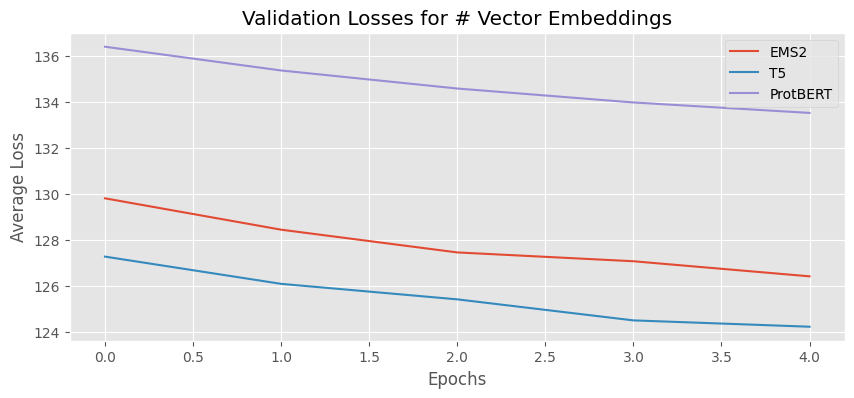

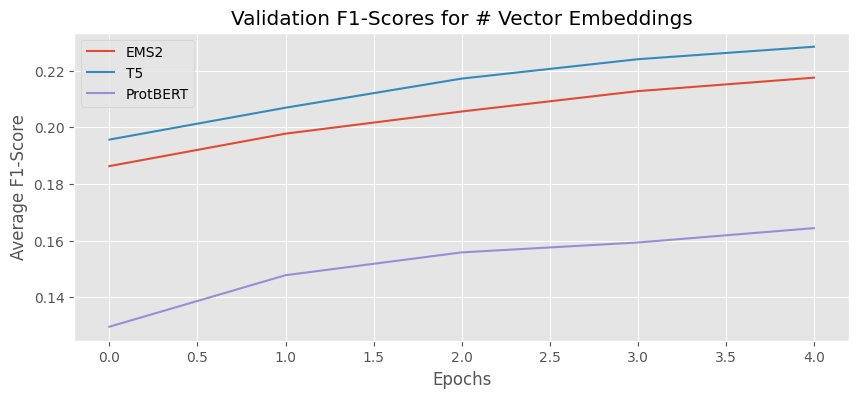

In [16]:
plt.figure(figsize = (10, 4))
plt.plot(ems2_losses["val"], label = "EMS2")
plt.plot(t5_losses["val"], label = "T5")
plt.plot(protbert_losses["val"], label = "ProtBERT")
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
plt.plot(ems2_scores["val"], label = "EMS2")
plt.plot(t5_scores["val"], label = "T5")
plt.plot(protbert_scores["val"], label = "ProtBERT")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

# 8. Make Predictions

In [17]:
def predict(embeddings_source):
    
    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    if embeddings_source == "T5":
        model = t5_model
    if embeddings_source == "ProtBERT":
        model = protbert_model
    if embeddings_source == "EMS2":
        model = ems2_model
        
    model.eval()
    
    labels = pd.read_csv(config.train_labels_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = top_terms[:config.num_labels].index.values
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(config.device)
        confs_[i*config.num_labels:(i+1)*config.num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*config.num_labels:(i+1)*config.num_labels] = id[0]
        go_terms_[i*config.num_labels:(i+1)*config.num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [18]:
submission_df = predict("T5")

GENERATE PREDICTION FOR TEST SET...


141865it [01:33, 1523.50it/s]


PREDICTIONS DONE


In [19]:
submission_df.head(50)

,Id,GO term,Confidence
0,Q9CQV8,GO:0005575,0.900060
1,Q9CQV8,GO:0008150,0.894986
2,Q9CQV8,GO:0110165,0.893226
3,Q9CQV8,GO:0003674,0.891319
4,Q9CQV8,GO:0005622,0.882667
5,Q9CQV8,GO:0009987,0.856230
6,Q9CQV8,GO:0043226,0.874933
7,Q9CQV8,GO:0043229,0.862011
8,Q9CQV8,GO:0005488,0.882287
9,Q9CQV8,GO:0043227,0.861707


In [20]:
len(submission_df)

70932500

In [21]:
submission_df.to_csv('submission.tsv', sep='\t', index=False)

### *I appreciate any feedback or Upvote as support*
### *Also open for teaming, contact me in comments or mp*